# SHO Fitting Data

## Import Packages

In [1]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [2]:
%load_ext autoreload
# import gdown
import time
import h5py
import pyUSID as usid
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import style
from m3_learning.be.util import print_be_tree
from m3_learning.be.processing import convert_amp_phase, fit_loop_function, SHO_Fitter, SHO_fit_to_array, loop_lsqf
from m3_learning.viz.layout import layout_fig
from m3_learning.util.h5_util import make_dataset, make_group
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './figures/')

from scipy.signal import resample
from scipy import fftpack


style("default")
random_seed(seed=42)

%matplotlib inline


2023-03-30 00:24:54.408410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 00:24:54.524630: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-30 00:24:54.959255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-30 00:24:54.959304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loading data for SHO fitting


In [3]:
path = r"./"

In [4]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = 'data_file_raw_fitted copy.h5'
save_path = './'

# download the file
download_and_unzip(filename, url, save_path)

Using files already downloaded


Prints the Tree to show the Data Structure

In [5]:
# instantiate the dataset object
dataset = BE_Dataset("./data_file_raw.h5", testing=True)

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
    ├ complex
      -------
      ├ imag
      ├ imag_resampled
      ├ real
      ├ real_resampled
    ├ magnitude_spectrum
      ------------------
      ├ amplitude
      ├ phase
   

## SHO Fitting
**Note**: this code takes around 15 minutes to execute

In [6]:
# computes the SHO fit for the data in the file
# dataset.SHO_Fitter(force = True)

### Visualize Raw Data

3174 348


/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


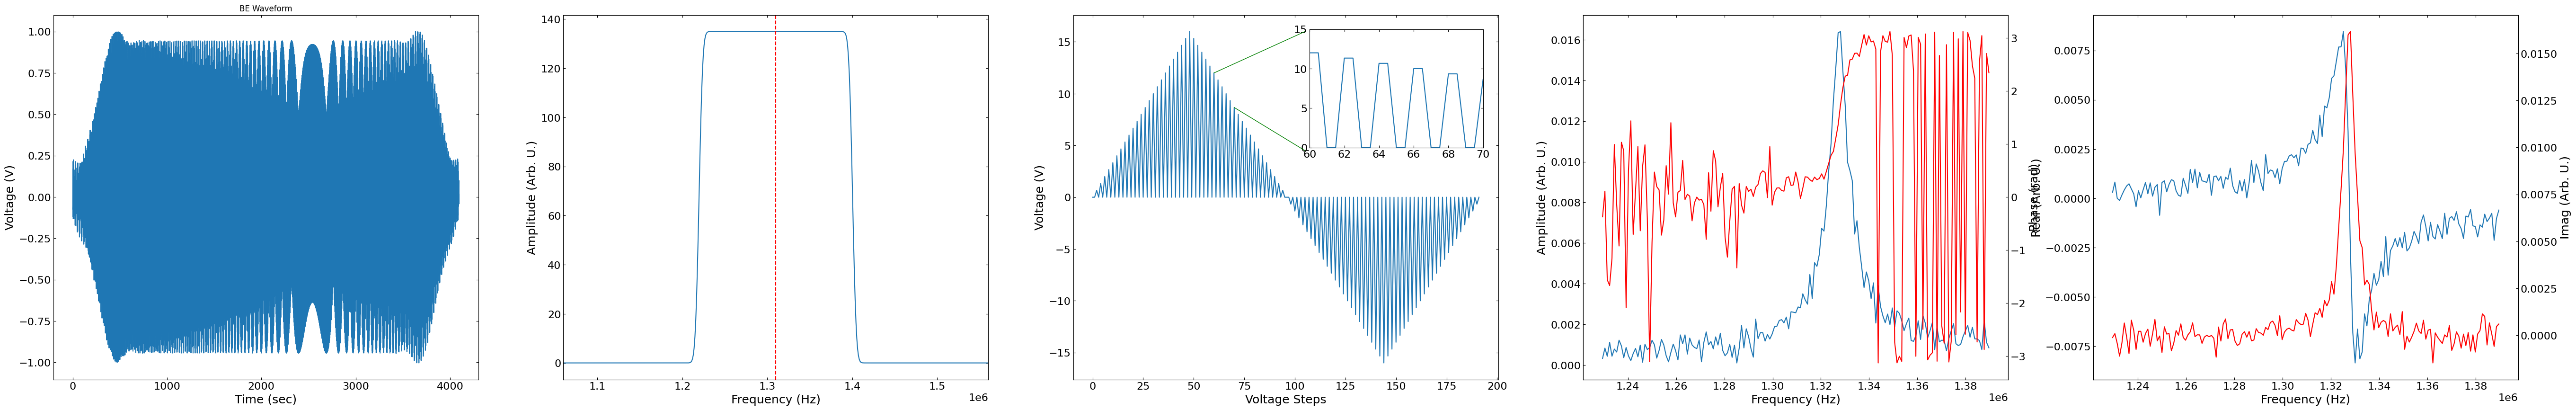

In [7]:
dataset.lsqf_viz.raw_be()

### Plots the SHO Fit Results

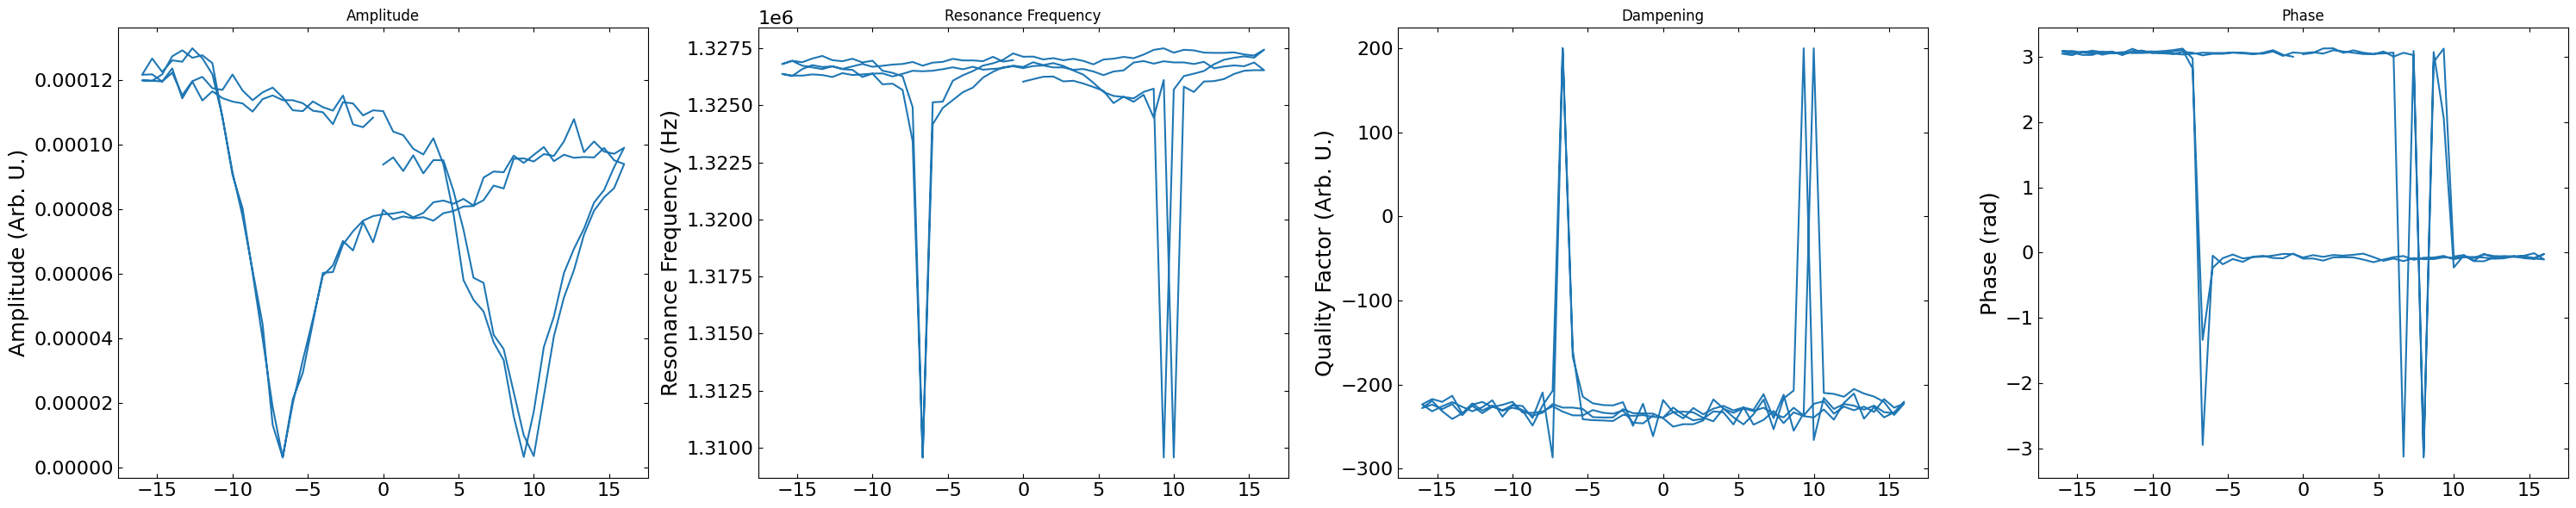

In [8]:
dataset.lsqf_viz.SHO_loops()

### Visualize the SHO Fit Results

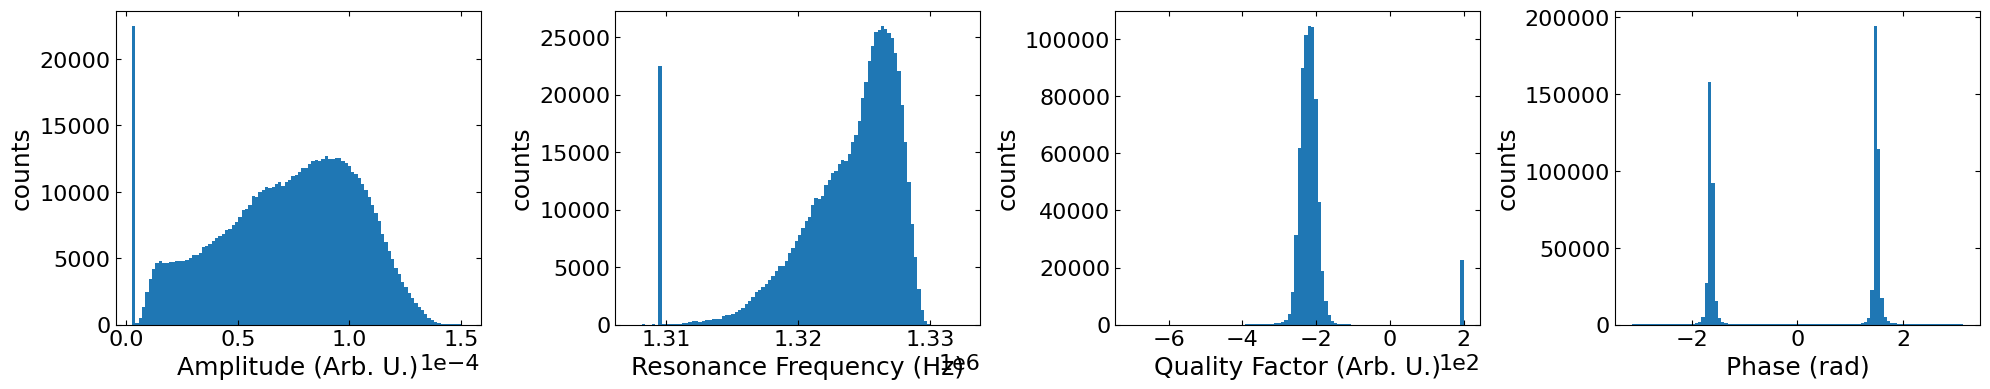

In [9]:
dataset.lsqf_viz.shift = np.pi/2
dataset.lsqf_viz.SHO_hist()


## Preprocessing

In [10]:
dataset.resample_bins = 80
dataset.complex_spectrum_imag_resampled
dataset.complex_spectrum_real_resampled

dataset.raw_data_resampled
dataset.magnitude_spectrum_resampled
dataset.magnitude_spectrum_amplitude_resampled

could not add group - it might already exist


array([[[5.52050828e-04, 2.84977927e-04, 2.64405564e-04, ...,
         2.73224723e-04, 3.77547403e-04, 5.87638060e-04],
        [2.10831364e-04, 3.62578256e-04, 2.89097050e-04, ...,
         3.58292717e-04, 1.55826201e-04, 2.05771910e-04],
        [2.68565258e-04, 4.79814480e-05, 2.41425092e-04, ...,
         1.87508180e-04, 2.92620738e-04, 3.06437461e-04],
        ...,
        [4.72018670e-04, 3.16577905e-04, 7.21216958e-04, ...,
         1.23432511e-03, 9.19440645e-04, 1.06759369e-03],
        [3.59706988e-04, 1.99581569e-04, 6.33993419e-04, ...,
         7.10938184e-04, 2.28543518e-04, 9.04289773e-04],
        [4.90732316e-04, 2.80697132e-04, 3.47352616e-05, ...,
         7.45299854e-04, 9.26190696e-04, 8.51614401e-04]],

       [[4.63733071e-04, 8.60998989e-05, 1.63922581e-04, ...,
         3.95697920e-04, 6.69969828e-04, 1.55231362e-04],
        [7.93568252e-05, 1.56740876e-04, 7.26139464e-04, ...,
         3.55092168e-04, 2.62443355e-04, 2.62633024e-04],
        [4.47538448e-04, 

In [ ]:
# need to check if h5 file has a datagroup

In [ ]:
dataset.print_be_tree()

In [ ]:
# # resamples the real and imaginary components
# real_resample = resample(real.reshape(num_pix, -1, num_bins), 80, axis=2)
# imag_resample = resample(imag.reshape(num_pix, -1, num_bins), 80, axis=2)

# resamples the raw data
raw_data_resample = resample(np.array(
    h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# resamples the amplitude values
amp_resample, phase_resample = convert_amp_phase(raw_data_resample)

# makes a new object in the h5 file to store the resampled data
make_group(h5_f["Measurement_000"]["Channel_000"], 'magn_spec_resample')

# adds the resampled data to the h5 file
make_dataset(h5_f["Measurement_000"]["Channel_000"],
             'raw_data_resample', raw_data_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]
             ['complex'], 'real_resample', real_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]
             ['complex'], 'imag_resample', imag_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]
             ['magn_spec_resample'], 'amp_resample', amp_resample)
make_dataset(h5_f["Measurement_000"]["Channel_000"]
             ['magn_spec_resample'], 'phase_resample', phase_resample)


In [ ]:
with dataset.dataset